<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install -q xlrd

In [0]:
 #!git clone https://smahesh2694:@github.com/smahesh2694/NEU_CLS-64.git

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained

In [6]:
base_model=MobileNet(weights='imagenet',include_top=False)  #input_shape= (200, 200, 3)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '




17227776/17225924 [==============================] - 0s 0us/step


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(6,activation='softmax')(x)

In [0]:
model=Model(inputs=base_model.input, outputs=preds)

In [0]:
#model.summary()

We start by freezing all of the base model’s layers. We don’t want to train those layers since we are trying to leverage the knowledge learned by the network from the previous dataset (in this case ImageNet). By setting the layer.trainable=False , we are telling Keras not to update those weights during training, which is exactly what we want!

In [0]:
base_model.trainable = False 

get the validation data

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 validation_split=0.2)

In [0]:
bs = 16

In [13]:
train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train',  
                                                 target_size=(200,200),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training')

Found 1296 images belonging to 6 classes.


In [14]:
label_map = (train_generator.class_indices)
print(label_map)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}


In [15]:
val_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train', 
                                                 target_size=(200,200),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 324 images belonging to 6 classes.


In [16]:
#sgd = SGD(lr=0.01, clipvalue=0.5)
model.compile(optimizer=SGD(),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [18]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)
step_size_val=val_generator.n//val_generator.batch_size
print(step_size_val)

81
20


In [0]:
initial_epochs = 25

In [0]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

In [0]:
#print(history.history.keys())

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

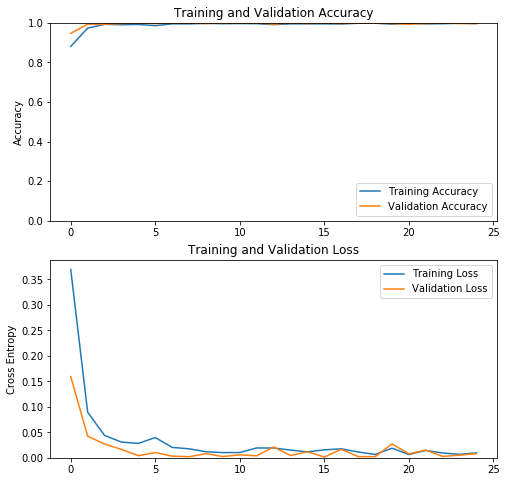

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.savefig('/content/drive/My Drive/xai_model/MN_80_20_SGD_25.jpg')
plt.show()



In [0]:
base_model.trainable = True

In [25]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  87


In [0]:
fine_tune_at = 59

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
#model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [30]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs)

Epoch 26/40


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


81/81 [==============================] - 25s 304ms/step - loss: 0.0055 - acc: 0.9992 - val_loss: 0.0120 - val_acc: 0.9969
Epoch 27/40
81/81 [==============================] - 23s 284ms/step - loss: 0.0039 - acc: 0.9992 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 28/40
81/81 [==============================] - 23s 284ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9935
Epoch 29/40
81/81 [==============================] - 23s 281ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 0.9968
Epoch 30/40
81/81 [==============================] - 23s 280ms/step - loss: 0.0037 - acc: 0.9985 - val_loss: 0.0054 - val_acc: 0.9968
Epoch 31/40
81/81 [==============================] - 23s 279ms/step - loss: 0.0032 - acc: 0.9992 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 32/40
81/81 [==============================] - 24s 301ms/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 33/40
81/81 [==============================] - 24s 293ms/step - loss

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

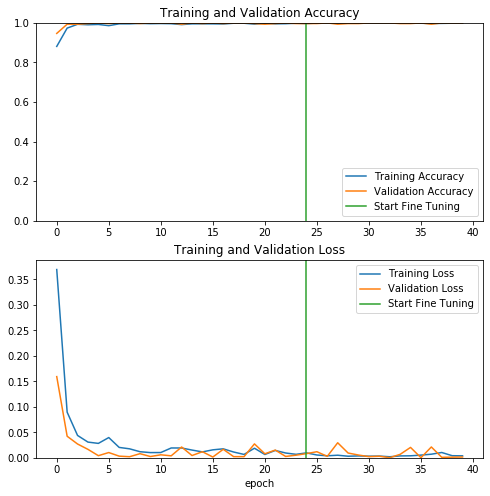

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/xai_model/MN_FT_80_20_SFD_25.jpg')
plt.show()

In [0]:
model.save('/content/drive/My Drive/xai_model/model_25.h5')

In [0]:
#model.save_weights('/content/drive/My Drive/xai_model/weights_24.h5')

Prediction on model 23

In [0]:
#saved_model = load_model('/content/drive/My Drive/xai_model/model.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [37]:
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Test',
                                                  target_size=(200,200),     
                                                  batch_size=16,
                                                  class_mode='categorical',
                                                  shuffle = False)

Found 180 images belonging to 6 classes.


In [0]:
predIndxs = model.predict_generator(test_generator,steps = (test_generator.n//test_generator.batch_size)+1 )

In [0]:
predIndxs = np.argmax(predIndxs, axis=1)

In [40]:
print(classification_report(test_generator.classes, predIndxs, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

          Cr       1.00      1.00      1.00        30
          In       0.97      1.00      0.98        30
          PS       1.00      1.00      1.00        30
          Pa       1.00      1.00      1.00        30
          RS       1.00      1.00      1.00        30
          Sc       1.00      0.97      0.98        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



In [0]:
cm = confusion_matrix(test_generator.classes,predIndxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5]) / total
#sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) sensitivity of each class 
#specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [42]:
print(cm)
print("Accuracy: {:.4f}".format(acc))
#print("Sensitivity: {:.4f}".format(sensitivity))
#print("Specificity: {:.4f}".format(specificity))

[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 0  1  0  0  0 29]]
Accuracy: 0.9944


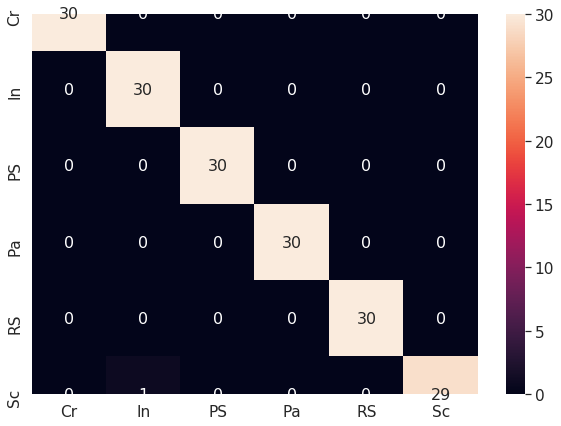

In [43]:
import seaborn as sn
import pandas as pd
    
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, annot=True,annot_kws={"size": 16})
plt.savefig('/content/drive/My Drive/xai_model/MN_CM_25.jpg')